# Нейросети в обработке текста

Берем отызывы за лето (из архива с материалами или предыдущего занятия)
1. Учим conv сеть для классификации
2. Рассмотреть 2-а варианта сеточек
2.1. Инициализировать tf.keras.layers.Embedding предобученными векторами взять к примеру с https://rusvectores.org/ru/
2.2. Инициализировать слой tf.keras.layers.Embedding по умолчанию (ну то есть вам ничего не делать с весами)
Сравнить две архитектуры с предобученными весами и когда tf.keras.layers.Embedding обучается сразу со всей сеточкой, что получилось лучше


In [1]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re
import numpy as np
import keras
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Input, Embedding, Conv1D, GlobalMaxPool1D
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.callbacks import TensorBoard 
from keras.callbacks import EarlyStopping  
#from keras.objectives import categorical_crossentropy

from keras.metrics import categorical_crossentropy

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score 

from gensim.models import Word2Vec


import tqdm

nltk.download("punkt")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\chinyaev.av\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
max_words = 200
max_len = 40
num_classes = 1

# Training
epochs = 20
batch_size = 128
print_batch_n = 100

In [3]:
df_train = pd.read_csv("imdb/train.tsv",delimiter="\t",header=0)
df_test = pd.read_csv("imdb/test.tsv",delimiter="\t",header=0)
df_val = df_test[:(len(df_test)//2)]
df_test = df_test[(len(df_test)//2):]

In [4]:
df_train.head()

,is_positive,review
0,0,"Dreamgirls, despite its fistful of Tony wins i..."
1,0,This show comes up with interesting locations ...
2,1,I simply love this movie. I also love the Ramo...
3,0,Spoilers ahead if you want to call them that.....
4,1,My all-time favorite movie! I have seen many m...


In [5]:
df_test.head()

,is_positive,review
12500,1,This show came to Canada via PBS in the mid 90...
12501,0,Wow... just... wow. There are a lot of reviews...
12502,0,This movie is the worst thing ever created by ...
12503,0,I'm just throwing in this review to show that ...
12504,0,"Okay,I had watched this movie when I was very ..."


In [6]:
df_val.head()

,is_positive,review
0,0,A formulaic story with all the tired cliches. ...
1,1,This is both an entertaining and a touching ve...
2,0,Corey Haim is never going to be known as one o...
3,1,If you believe that any given war movie can ma...
4,1,Carla Gugino literally melts the screen in thi...


### Предобработка

In [7]:
sw = set(get_stop_words("en"))
sw = sw.union( {"t",'br','s'})
exclude = set(punctuation)
morpher = MorphAnalyzer()

def preprocess_text(txt):
    txt = str(txt).lower()
    t=str('')
    for c in txt:
        if c not in exclude:
            t = t+''.join(c)
        else:
            t = t+' '
    txt = ''.join(t)
    txt = re.sub(r'\d+', '', txt)
    txt = re.sub("\sне", "не", txt)
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    return " ".join(txt)



In [8]:
%%time
df_train['review'] = df_train['review'].apply(preprocess_text)

Wall time: 1min 27s


In [9]:
df_train['review']

0        dreamgirls despite fistful tony wins incredibl...
1        show comes interesting locations fast travel c...
2        simply love movie also love ramones sorta bias...
3        spoilers ahead want call almost recommend film...
4        time favorite movie seen many movies one beats...
                               ...                        
24995    big fan movie usual reasons think travolta win...
24996    m going bother plot synopsis since know movie ...
24997    movie don know take indellible character pippi...
24998    saw film dvd yesterday gob smacked flabbergast...
24999    disappointment none nuance original brits just...
Name: review, Length: 25000, dtype: object

In [10]:
%%time
df_val['review'] = df_val['review'].apply(preprocess_text)
df_test['review'] = df_test['review'].apply(preprocess_text)

Wall time: 1min 25s


In [11]:
%%time
train_corpus = " ".join(df_train["review"])
train_corpus = train_corpus.lower()

Wall time: 241 ms


In [12]:
%%time
tokens = word_tokenize(train_corpus)

Wall time: 10.4 s


Отфильтруем данные

и соберём в корпус N наиболее частых токенов

In [13]:
tokens_filtered = [word for word in tokens if word.isalnum()]

In [14]:
from nltk.probability import FreqDist
dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]

In [15]:
tokens_filtered_top[:10]

['movie',
 'film',
 'one',
 'like',
 'just',
 'good',
 'can',
 'time',
 'even',
 'story']

In [16]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}

In [17]:
vocabulary

{'movie': 1,
 'film': 2,
 'one': 3,
 'like': 4,
 'just': 5,
 'good': 6,
 'can': 7,
 'time': 8,
 'even': 9,
 'story': 10,
 'really': 11,
 'see': 12,
 'well': 13,
 'much': 14,
 'get': 15,
 'bad': 16,
 'people': 17,
 'will': 18,
 'also': 19,
 'first': 20,
 'great': 21,
 'don': 22,
 'made': 23,
 'make': 24,
 'way': 25,
 'movies': 26,
 'think': 27,
 'characters': 28,
 'character': 29,
 'watch': 30,
 'two': 31,
 'films': 32,
 'seen': 33,
 'many': 34,
 'life': 35,
 'plot': 36,
 'acting': 37,
 'never': 38,
 'love': 39,
 'little': 40,
 'best': 41,
 'show': 42,
 'know': 43,
 'ever': 44,
 'man': 45,
 'better': 46,
 'end': 47,
 'still': 48,
 'say': 49,
 'scene': 50,
 'scenes': 51,
 'go': 52,
 've': 53,
 'something': 54,
 'm': 55,
 'back': 56,
 'real': 57,
 'watching': 58,
 'now': 59,
 'though': 60,
 'doesn': 61,
 'thing': 62,
 'old': 63,
 'years': 64,
 're': 65,
 'actors': 66,
 'director': 67,
 'work': 68,
 'didn': 69,
 'another': 70,
 'new': 71,
 'nothing': 72,
 'funny': 73,
 'actually': 74,
 'ma

In [18]:
def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])
    padding = [0]*(maxlen-len(result))
    return padding + result[-maxlen:]

In [19]:
x_train = np.asarray([text_to_sequence(text, max_len) for text in df_train["review"]], dtype=np.int32)
x_test = np.asarray([text_to_sequence(text, max_len) for text in df_test["review"]], dtype=np.int32)
x_val = np.asarray([text_to_sequence(text, max_len) for text in df_val["review"]], dtype=np.int32)

In [20]:
x_train.shape

(25000, 40)

In [21]:
max_len

40

In [22]:
x_train[0]

array([  2,  27,  21,   9,  60,   2,  24,  48,  10,  14,   4,  75,  97,
         2,  75,  42,  84,  50, 139,  76, 136,  13, 115,  13,  37, 160,
        85,   3,   2,  56, 192,   2, 157,  34,   2, 147,   2,  47, 133,
         7])

In [23]:
import pkg_resources
from dca.api import dca

print(f"dca v{pkg_resources.get_distribution('dca').version}")
print(f"keras v{pkg_resources.get_distribution('keras').version}")

dca v0.3.4
keras v2.4.3


C:\Users\chinyaev.av\AppData\Roaming\Python\Python37\site-packages\kopt\config.py:60: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  _config = yaml.load(open(_config_path))


In [24]:

keras.__version__

'2.4.3'

# Keras model

In [25]:
num_classes = len(df_train.is_positive.unique())
num_classes

2

In [26]:
y_train = keras.utils.to_categorical(df_train["is_positive"], num_classes)
y_val = keras.utils.to_categorical(df_val["is_positive"], num_classes)

In [27]:
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
model.add(Conv1D(128, 3))
model.add(Activation("relu"))
model.add(GlobalMaxPool1D())
model.add(Dense(10))
model.add(Activation("relu"))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [28]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [29]:
tensorboard=TensorBoard(log_dir='./logs2', write_graph=True, write_images=True)
early_stopping=EarlyStopping(monitor='val_loss')  


history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_val, y_val),
                    callbacks=[tensorboard, early_stopping])

Epoch 1/20
196/196 [==============================] - 7s 31ms/step - loss: 0.6292 - accuracy: 0.6508 - val_loss: 0.4940 - val_accuracy: 0.7588
Epoch 2/20
196/196 [==============================] - 5s 25ms/step - loss: 0.4803 - accuracy: 0.7713 - val_loss: 0.4821 - val_accuracy: 0.7632
Epoch 3/20
196/196 [==============================] - 5s 26ms/step - loss: 0.4383 - accuracy: 0.7970 - val_loss: 0.4744 - val_accuracy: 0.7694
Epoch 4/20
196/196 [==============================] - 5s 26ms/step - loss: 0.4066 - accuracy: 0.8143 - val_loss: 0.4763 - val_accuracy: 0.7722


In [30]:
import matplotlib.pyplot as plt
def plot_history(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='lower right')
    plt.show()

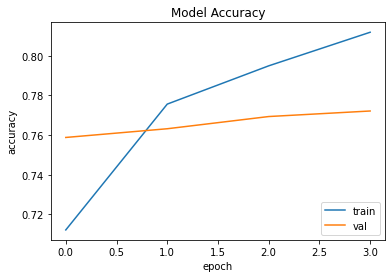

In [31]:
plot_history(history)

In [32]:
score = model.evaluate(x_val, y_val, batch_size=batch_size, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

98/98 [==============================] - 1s 6ms/step - loss: 0.4763 - accuracy: 0.7722


Test score: 0.4763098955154419
Test accuracy: 0.772159993648529


In [33]:
results = model.predict(x_test, batch_size=batch_size, verbose=1)

98/98 [==============================] - 1s 6ms/step


In [34]:
vect = TfidfVectorizer(ngram_range=(1, 2), analyzer='word', lowercase=False)

In [35]:
train_ft = vect.fit_transform(df_train['review'])
valid_ft = vect.transform(df_val['review'])

In [36]:
lgr = LogisticRegression(max_iter=1000)

In [37]:
lgr.fit(train_ft, df_train['is_positive'].to_numpy())

LogisticRegression(max_iter=1000)

In [38]:
y_pred = lgr.predict(valid_ft)

In [39]:
accuracy_score(df_val['is_positive'].to_numpy(), y_pred)

0.88016

In [40]:
df_train['review']

0        dreamgirls despite fistful tony wins incredibl...
1        show comes interesting locations fast travel c...
2        simply love movie also love ramones sorta bias...
3        spoilers ahead want call almost recommend film...
4        time favorite movie seen many movies one beats...
                               ...                        
24995    big fan movie usual reasons think travolta win...
24996    m going bother plot synopsis since know movie ...
24997    movie don know take indellible character pippi...
24998    saw film dvd yesterday gob smacked flabbergast...
24999    disappointment none nuance original brits just...
Name: review, Length: 25000, dtype: object

In [41]:
modelW2V = Word2Vec(sentences=df_train['review'].apply(str.split), vector_size=100, window=5, min_count=5, workers=8)

2022-06-07 20:27:00,068 [INFO] collecting all words and their counts
2022-06-07 20:27:00,069 [INFO] PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-06-07 20:27:00,362 [INFO] PROGRESS: at sentence #10000, processed 1209068 words, keeping 50780 word types
2022-06-07 20:27:00,643 [INFO] PROGRESS: at sentence #20000, processed 2442824 words, keeping 67453 word types
2022-06-07 20:27:00,823 [INFO] collected 74047 word types from a corpus of 3066536 raw words and 25000 sentences
2022-06-07 20:27:00,824 [INFO] Creating a fresh vocabulary
2022-06-07 20:27:00,969 [INFO] Word2Vec lifecycle event {'msg': 'effective_min_count=5 retains 28652 unique words (38.69% of original 74047, drops 45395)', 'datetime': '2022-06-07T20:27:00.969601', 'gensim': '4.2.0', 'python': '3.7.11 (default, Jul 27 2021, 09:42:29) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'prepare_vocab'}
2022-06-07 20:27:00,970 [INFO] Word2Vec lifecycle event {'msg': 'effective_

In [42]:
modelW2V.wv

In [43]:
vect_idf = TfidfVectorizer()
vect_idf.fit_transform(df_train['review'])
tfidf = dict(zip(vect_idf.get_feature_names_out(), vect_idf.idf_))

In [44]:
tfidf

{'aa': 9.334911633822305,
 'aaa': 9.180760953995046,
 'aaaaaaah': 10.433523922490414,
 'aaaaah': 10.433523922490414,
 'aaaaatch': 10.433523922490414,
 'aaaahhhhhhh': 10.433523922490414,
 'aaaand': 10.433523922490414,
 'aaaarrgh': 10.433523922490414,
 'aaah': 10.433523922490414,
 'aaargh': 9.517233190616258,
 'aaaugh': 10.433523922490414,
 'aaawwwwnnn': 10.433523922490414,
 'aachen': 10.433523922490414,
 'aada': 10.433523922490414,
 'aadha': 10.433523922490414,
 'aag': 8.641764453262358,
 'aage': 9.740376741930469,
 'aaghh': 10.433523922490414,
 'aah': 10.433523922490414,
 'aahhh': 10.433523922490414,
 'aaip': 10.433523922490414,
 'aaja': 10.433523922490414,
 'aakash': 10.433523922490414,
 'aaker': 10.02805881438225,
 'aakrosh': 10.433523922490414,
 'aaliyah': 10.433523922490414,
 'aames': 8.728775830251989,
 'aamir': 9.334911633822305,
 'aan': 10.02805881438225,
 'aankh': 10.433523922490414,
 'aankhen': 9.334911633822305,
 'aap': 10.433523922490414,
 'aapke': 9.517233190616258,
 'aapke

In [45]:
rt = vect_idf.vocabulary_.items()

In [46]:
tfidf['abercrombie']

9.740376741930469

In [47]:
vect_idf.idf_[vect_idf.vocabulary_['abercrombie']]

9.740376741930469

In [48]:
len(tfidf)

73452

In [49]:
from collections import defaultdict

In [50]:
defaultdict

collections.defaultdict

In [51]:
max_idf = max(vect_idf.idf_)

word2weight = defaultdict(
    lambda: max_idf,
    [(w, vect_idf.idf_[i]) for w, i in vect_idf.vocabulary_.items()])

In [52]:
def get_vect_mean(txt):
    vector_w2v = np.zeros(100)
    n_w2v = 0
    for wrd in txt.split():
        if wrd in modelW2V.wv.index_to_key:
            vector_w2v += modelW2V.wv[wrd]
            n_w2v += 1
    if n_w2v > 0:
        vector_w2v = vector_w2v / n_w2v
    return vector_w2v

def get_vect_idf(txt):
    vector_w2v = np.zeros(100)
    n_w2v = 0
    for wrd in txt.split():
        if wrd in modelW2V.wv.index_to_key:
            iddf_ = tfidf.get(wrd, 1.)
            vector_w2v += modelW2V.wv[wrd]*iddf_
            n_w2v += iddf_
    if n_w2v > 0:
        vector_w2v = vector_w2v / n_w2v
    return vector_w2v

In [53]:
from tqdm.notebook import tqdm_notebook

In [54]:
arr_vect = []
for txt in tqdm_notebook(df_train['review']):
    arr_vect.append(get_vect_mean(txt))
    
arr_vect_valid = []
for txt in tqdm_notebook(df_val['review']):
    arr_vect_valid.append(get_vect_mean(txt))
    
train_w2v = np.asarray(arr_vect)    
valid_w2v = np.asarray(arr_vect_valid)

  0%|          | 0/25000 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

In [55]:
lgr_w2v = LogisticRegression(solver='lbfgs', max_iter=1000)

In [56]:
lgr_w2v.fit(train_w2v, df_train['is_positive'].to_numpy())

LogisticRegression(max_iter=1000)

In [57]:
y_pred = lgr_w2v.predict(valid_w2v)

In [58]:
accuracy_score(df_val['is_positive'].to_numpy(), y_pred)

0.84672

In [59]:
arr_vect = []
for txt in tqdm.notebook.tqdm(df_train['review']):
    arr_vect.append(get_vect_idf(txt))
    
arr_vect_valid = []
for txt in tqdm.notebook.tqdm(df_val['review']):
    arr_vect_valid.append(get_vect_idf(txt))
    
train_w2v = np.asarray(arr_vect)    
valid_w2v = np.asarray(arr_vect_valid)

  0%|          | 0/25000 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

In [60]:
lgr_w2v = LogisticRegression(solver='lbfgs', max_iter=1000)
lgr_w2v.fit(train_w2v, df_train['is_positive'].to_numpy())
y_pred = lgr_w2v.predict(valid_w2v)

In [61]:
accuracy_score(df_val['is_positive'].to_numpy(), y_pred)

0.8484

In [62]:
import matplotlib.pyplot as plt
def plot_history(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='lower right')
    plt.show()

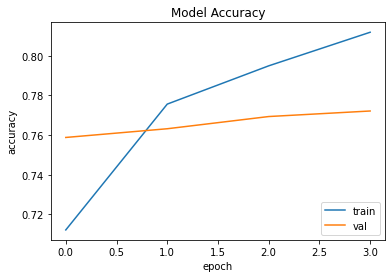

In [63]:
plot_history(history)

### Используем готовую модель

In [64]:
#import fasttext  
from gensim.models import KeyedVectors
from gensim.test.utils import datapath
import gensim
import zipfile

2022-06-07 20:47:35,142 [INFO] adding document #0 to Dictionary<0 unique tokens: []>
2022-06-07 20:47:35,142 [INFO] built Dictionary<12 unique tokens: ['computer', 'human', 'interface', 'response', 'survey']...> from 9 documents (total 29 corpus positions)
2022-06-07 20:47:35,143 [INFO] Dictionary lifecycle event {'msg': "built Dictionary<12 unique tokens: ['computer', 'human', 'interface', 'response', 'survey']...> from 9 documents (total 29 corpus positions)", 'datetime': '2022-06-07T20:47:35.143358', 'gensim': '4.2.0', 'python': '3.7.11 (default, Jul 27 2021, 09:42:29) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'created'}


In [65]:
# Загружаем модель"British National Corpus" по http://vectors.nlpl.eu/repository/20/0.zip

In [66]:
#model_file = './model/model.bin'

In [67]:
model_file = '0.zip'
with zipfile.ZipFile(model_file, 'r') as archive:
    stream = archive.open('model.bin')
    en_emb = gensim.models.KeyedVectors.load_word2vec_format(stream, binary=True)

2022-06-07 20:47:35,276 [INFO] loading projection weights from <zipfile.ZipExtFile name='model.bin' mode='r' compress_type=deflate>
2022-06-07 20:47:38,729 [INFO] KeyedVectors lifecycle event {'msg': 'loaded (163473, 300) matrix of type float32 from <zipfile.ZipExtFile [closed]>', 'binary': True, 'encoding': 'utf8', 'datetime': '2022-06-07T20:47:38.729826', 'gensim': '4.2.0', 'python': '3.7.11 (default, Jul 27 2021, 09:42:29) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'load_word2vec_format'}


In [68]:
def code_w2v_txt(txt, max_len = 100):
    sent_w2v = []
    zero_point = np.zeros(300)
    txt = txt.split()
   
    for i in range(max_len):
        try:
            word = en_emb[txt[i]]
        except:
            word = zero_point
        sent_w2v.append(word)
    return np.array(sent_w2v)

In [69]:
df_train['w2v'] = df_train['review'].apply(code_w2v_txt, max_len = max_len)

In [70]:
df_train.head()

,is_positive,review,w2v
0,0,dreamgirls despite fistful tony wins incredibl...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,0,show comes interesting locations fast travel c...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,1,simply love movie also love ramones sorta bias...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,0,spoilers ahead want call almost recommend film...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,1,time favorite movie seen many movies one beats...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [71]:
x_train = np.array(list(df_train['w2v'].values))
y_train = df_train['is_positive'].values

In [72]:
x_val = np.array(list(df_val['review'].apply(code_w2v_txt, max_len = max_len).values))
x_test = np.array(list(df_test['review'].apply(code_w2v_txt, max_len = max_len).values))
y_val = df_val['is_positive'].values
y_test = df_test['is_positive'].values

In [73]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train) 
y_test = le.transform(y_test)

In [74]:
import tensorflow.keras.layers as Layer
from tensorflow.keras import Model, Sequential

num_classes = len(df_train.is_positive.unique())
# Строим точно такую же модель на предобученных векторах
model = Sequential()
model.add(Layer.Input(shape=(x_train.shape[1], x_train.shape[2])))
model.add(Layer.Conv1D(128, 3))
model.add(Layer.Bidirectional(Layer.LSTM(units=32, return_sequences=True, activation="relu")))
model.add(Layer.GlobalMaxPool1D())
model.add(Layer.Dense(32, activation="relu"))
model.add(Layer.Dense(num_classes, activation="softmax"))

In [75]:
model.summary()
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 38, 128)           115328    
_________________________________________________________________
bidirectional (Bidirectional (None, 38, 64)            41216     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 66        
Total params: 158,690
Trainable params: 158,690
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
196/196 [==============================] - 15s 69ms/step - loss: 0.6932 - accuracy: 0.5059 - val_loss: 0.6931 - val_accuracy: 0.5052
Epoch 2/20
196/196 [==============================] - 11s 58ms/step - loss: 0.6932 - accuracy: 0.4983 - val_loss: 0.6931 - val_accuracy: 0.5052
Epoch 3/20
196/196 [==============================] - 12s 59ms/step - loss: 0.6932 - accuracy: 0.4993 - val_loss: 0.6931 - val_accuracy: 0.5052
Epoch 4/20
196/196 [==============================] - 12s 60ms/step - loss: 0.6932 - accuracy: 0.4945 - val_loss: 0.6931 - val_accuracy: 0.5052


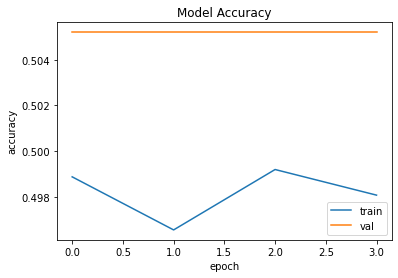

In [76]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

history = model.fit(x_train, y_train, batch_size=128, epochs=epochs, 
           callbacks=[callback],validation_data=(x_val, y_val))
plot_history(history)

In [77]:
score = model.evaluate(x_val, y_val, batch_size=batch_size, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])
results = model.predict(x_test, batch_size=batch_size, verbose=1)
vect = TfidfVectorizer(ngram_range=(1, 2), analyzer='word', lowercase=False)
train_ft = vect.fit_transform(df_train['review'])
valid_ft = vect.transform(df_val['review'])
lgr = LogisticRegression(max_iter=1000)
history = lgr.fit(train_ft, df_train['is_positive'].to_numpy())
y_pred = lgr.predict(valid_ft)
accuracy_score(df_val['is_positive'].to_numpy(), y_pred)

98/98 [==============================] - 3s 27ms/step - loss: 0.6931 - accuracy: 0.5052


Test score: 0.6931416988372803
Test accuracy: 0.5052000284194946
98/98 [==============================] - 2s 18ms/step


0.88016